In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('../src')
from functions import *

df_clients_profile = pd.read_csv('../Data/raw/df_final_demo.txt')
df_web_data_1 = pd.read_csv('../Data/raw/df_final_web_data_pt_1.txt')
df_web_data_2 = pd.read_csv('../Data/raw/df_final_web_data_pt_2.txt')
df_experiment_clients = pd.read_csv('../Data/raw/df_final_experiment_clients.txt')
pd.set_option('display.max_columns', None)
df_web_data = pd.concat([df_web_data_1, df_web_data_2], ignore_index= True)

In [2]:
df_web_data.head(10)

,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04
5,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:17:15
6,9988021,580560515_7732621733,781255054_21935453173_531117,step_1,2017-04-17 15:17:01
7,9988021,580560515_7732621733,781255054_21935453173_531117,start,2017-04-17 15:16:22
8,8320017,39393514_33118319366,960651974_70596002104_312201,confirm,2017-04-05 13:10:05
9,8320017,39393514_33118319366,960651974_70596002104_312201,step_3,2017-04-05 13:09:43


In [3]:
duplicate_visits = df_web_data.groupby('visit_id')['visitor_id'].nunique().gt(1)

# Filter out the groups with different 'visitor_id' values
visits_with_different_ids = duplicate_visits[duplicate_visits].index.tolist()
if visits_with_different_ids:
    print(f"Visit IDs with different visitor IDs: {visits_with_different_ids}")
else:
    print("No visit IDs with different visitor IDs found.")

No visit IDs with different visitor IDs found.


In [4]:
#lenght of the dataframes
lenght_clients_profile = print(df_clients_profile.shape)
lenght_experiment_clients = print(df_experiment_clients.shape)
lengt_web_data = print(df_web_data.shape)

(70609, 9)
(70609, 2)
(755405, 5)


In [5]:
#clean df
df_clients_profile = print_clean_data(df_clients_profile)

Before
client_id            0
clnt_tenure_yr      14
clnt_tenure_mnth    14
clnt_age            15
gendr               14
num_accts           14
bal                 14
calls_6_mnth        14
logons_6_mnth       14
dtype: int64
------------------------------------------
------------------------------------------
After
client_id           0
clnt_tenure_yr      0
clnt_tenure_mnth    0
clnt_age            0
gendr               0
num_accts           0
bal                 0
calls_6_mnth        0
logons_6_mnth       0
dtype: int64


In [6]:
#clean df
df_experiment_clients = print_clean_data(df_experiment_clients)

Before
client_id        0
Variation    20109
dtype: int64
------------------------------------------
To many NaN values in column: Variation
------------------------------------------
After
client_id        0
Variation    20109
dtype: int64


In [7]:
#clean df
df_web_data = print_clean_data(df_web_data)

Before
client_id       0
visitor_id      0
visit_id        0
process_step    0
date_time       0
dtype: int64
------------------------------------------
------------------------------------------
After
client_id       0
visitor_id      0
visit_id        0
process_step    0
date_time       0
dtype: int64


In [8]:
df_null_experiment_clients = df_experiment_clients.isna()
df_null_experiment_clients

,client_id,Variation
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
70604,False,True
70605,False,True
70606,False,True
70607,False,True


In [9]:
df_experiment_clients

,client_id,Variation
0,9988021,Test
1,8320017,Test
2,4033851,Control
3,1982004,Test
4,9294070,Control
...,...,...
70604,2443347,NaN
70605,8788427,NaN
70606,266828,NaN
70607,1266421,NaN


In [10]:
#setting aside the clients that wont be part if the experiment
null_df_experiment_clients = df_experiment_clients[df_experiment_clients['Variation'].isnull()]
null_df_experiment_clients

,client_id,Variation
50500,5459747,NaN
50501,8031000,NaN
50502,1847030,NaN
50503,9713157,NaN
50504,7775828,NaN
...,...,...
70604,2443347,NaN
70605,8788427,NaN
70606,266828,NaN
70607,1266421,NaN


In [11]:
#id of clients that are part of the test
df_experiment_clients_Test = df_experiment_clients[df_experiment_clients['Variation'] == 'Test']
df_experiment_clients_Test.head(10)


,client_id,Variation
0,9988021,Test
1,8320017,Test
3,1982004,Test
5,9466803,Test
6,3170143,Test
8,5887227,Test
10,438567,Test
11,2519971,Test
13,5407849,Test
16,5308474,Test


In [12]:
df_test = pd.merge(df_experiment_clients_Test, df_clients_profile, on='client_id', how='inner')
df_test = pd.merge(df_web_data, df_test, on='client_id', how='inner')
#change the data type to datetime
df_test['date_time'] = pd.to_datetime(df_test['date_time']) 

df_test_latest_confirm = df_test[df_test['process_step'] == 'confirm'].sort_values('date_time').drop_duplicates('visit_id', keep='last')

# Combine with other process steps
df_test = pd.concat([df_test_latest_confirm, df_test[df_test['process_step'] != 'confirm']])

# Sort the final DataFrame by the original index and date_time
df_test = df_test.sort_index().sort_values('date_time').reset_index(drop=True)
df_test.head(30)

,client_id,visitor_id,visit_id,process_step,date_time,Variation,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth
0,4192640,692067844_75217592829,706721307_85347845958_18583,start,2017-03-15 00:43:23,Test,14.0,174.0,54.0,M,2.0,97914.40,3.0,6.0
1,4192640,692067844_75217592829,706721307_85347845958_18583,step_1,2017-03-15 00:43:32,Test,14.0,174.0,54.0,M,2.0,97914.40,3.0,6.0
2,4192640,692067844_75217592829,706721307_85347845958_18583,step_2,2017-03-15 00:43:48,Test,14.0,174.0,54.0,M,2.0,97914.40,3.0,6.0
3,4192640,692067844_75217592829,706721307_85347845958_18583,step_1,2017-03-15 00:44:36,Test,14.0,174.0,54.0,M,2.0,97914.40,3.0,6.0
4,4192640,692067844_75217592829,706721307_85347845958_18583,start,2017-03-15 00:44:38,Test,14.0,174.0,54.0,M,2.0,97914.40,3.0,6.0
5,6752370,258848572_66112715827,147442660_10728929690_338280,start,2017-03-15 05:37:35,Test,38.0,464.0,22.0,M,2.0,56574.43,2.0,5.0
6,6752370,258848572_66112715827,147442660_10728929690_338280,step_1,2017-03-15 05:37:45,Test,38.0,464.0,22.0,M,2.0,56574.43,2.0,5.0
7,6752370,258848572_66112715827,147442660_10728929690_338280,step_1,2017-03-15 05:39:53,Test,38.0,464.0,22.0,M,2.0,56574.43,2.0,5.0
8,6752370,258848572_66112715827,147442660_10728929690_338280,step_2,2017-03-15 05:40:01,Test,38.0,464.0,22.0,M,2.0,56574.43,2.0,5.0
9,6752370,258848572_66112715827,147442660_10728929690_338280,step_1,2017-03-15 05:40:22,Test,38.0,464.0,22.0,M,2.0,56574.43,2.0,5.0


In [42]:
df_test['completion'] = df_test['process_step'].apply(lambda x: 1 if x == 'confirm' else 0)
df_test.head(10)

,client_id,visitor_id,visit_id,process_step,date_time,Variation,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,backward_move,time_spent_seconds,time_diff,completion
133221,3561384,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:23:09,Test,4.0,56.0,59.5,U,2.0,63130.44,6.0,9.0,False,NaN,NaN,1
77031,7338123,612065484_94198474375,100019538_17884295066_43909,start,2017-04-09 16:20:56,Test,7.0,88.0,23.5,M,2.0,26436.73,6.0,9.0,False,0.0,NaN,0
77032,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:12,Test,7.0,88.0,23.5,M,2.0,26436.73,6.0,9.0,False,16.0,16.0,0
77033,7338123,612065484_94198474375,100019538_17884295066_43909,step_2,2017-04-09 16:21:21,Test,7.0,88.0,23.5,M,2.0,26436.73,6.0,9.0,False,25.0,9.0,0
77034,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:35,Test,7.0,88.0,23.5,M,2.0,26436.73,6.0,9.0,False,39.0,14.0,0
77035,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:41,Test,7.0,88.0,23.5,M,2.0,26436.73,6.0,9.0,False,45.0,6.0,0
77036,7338123,612065484_94198474375,100019538_17884295066_43909,start,2017-04-09 16:21:45,Test,7.0,88.0,23.5,M,2.0,26436.73,6.0,9.0,True,49.0,4.0,0
77037,7338123,612065484_94198474375,100019538_17884295066_43909,start,2017-04-09 16:21:59,Test,7.0,88.0,23.5,M,2.0,26436.73,6.0,9.0,False,63.0,14.0,0
77038,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:22:04,Test,7.0,88.0,23.5,M,2.0,26436.73,6.0,9.0,False,68.0,5.0,0
77039,7338123,612065484_94198474375,100019538_17884295066_43909,step_2,2017-04-09 16:22:08,Test,7.0,88.0,23.5,M,2.0,26436.73,6.0,9.0,False,72.0,4.0,0


In [13]:
df_experiment_clients_Control = df_experiment_clients[df_experiment_clients['Variation'] == 'Control']
df_experiment_clients_Control.head(10)

,client_id,Variation
2,4033851,Control
4,9294070,Control
7,6651403,Control
9,2105948,Control
12,9814849,Control
14,7286739,Control
15,4446011,Control
20,4229407,Control
24,2842481,Control
27,1218661,Control


In [14]:
df_control = pd.merge(df_experiment_clients_Control, df_clients_profile, on='client_id', how='inner')
df_control = pd.merge(df_web_data, df_control, on='client_id', how='inner')
#change the data type to datetime
df_control['date_time'] = pd.to_datetime(df_control['date_time'])
df_latest_confirm = df_control[df_control['process_step'] == 'confirm'].sort_values('date_time').drop_duplicates('visit_id', keep='last')

# Combine with other process steps
df_control = pd.concat([df_latest_confirm, df_control[df_control['process_step'] != 'confirm']])

# Sort the final DataFrame by the original index and date_time
df_control = df_control.sort_index().sort_values('date_time').reset_index(drop=True)

You have now been asked to discover what key performance indicators (KPIs) will determine the success of the new design? Use at least completion rate, time spent on each step and error rates. Add any KPIs you might find relevant.

Completion Rate: The proportion of users who reach the final ‘confirm’ step.
Time Spent on Each Step: The average duration users spend on each step.
Error Rates: If there’s a step where users go back to a previous step, it may indicate confusion or an error. You should consider moving from a later step to an earlier one as an error.
Redesign Outcome
Based on the chosen KPIs, how does the new design’s performance compare to the old one

In [15]:
Completion_rate_test = df_test[df_test['process_step'] == 'confirm']['visit_id'].nunique() / df_test['visit_id'].nunique() * 100

In [16]:
Completion_rate_test

58.52324766984538

In [17]:
Completion_rate_control = df_control[df_control['process_step'] == 'confirm']['visit_id'].nunique() / df_test['visit_id'].nunique() * 100
Completion_rate_control

43.20618501158343

In [18]:
def calculate_time_spent(group):
    group = group.sort_values('date_time')
    group['time_spent'] = group['date_time'].diff().fillna(pd.Timedelta(seconds=0))
    time_spent = group.groupby('process_step')['time_spent'].mean().dt.total_seconds()
    return time_spent

time_spent_df = df_test.groupby('visit_id').apply(calculate_time_spent).reset_index()
average_time_spent = time_spent_df.groupby('process_step')['time_spent'].mean()

C:\Users\reetu\AppData\Local\Temp\ipykernel_11456\1827866774.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  time_spent_df = df_test.groupby('visit_id').apply(calculate_time_spent).reset_index()


In [19]:
average_time_spent

process_step
confirm    121.240736
start       34.467487
step_1      33.247190
step_2      41.511778
step_3      92.476381
Name: time_spent, dtype: float64

In [20]:
# Assuming 'previous_step' column indicates the previous step a user was at
df_test['backward_move'] = df_test.groupby('visit_id')['process_step'].shift(1) > df_test['process_step']
error_rate_test = (df_test['backward_move'].sum() / df_test['visit_id'].nunique() * 100).round(2)
error_rate_test

np.float64(92.52)

In [39]:
df_test['time_diff'] = df_test.groupby('visit_id')['date_time'].diff().dt.total_seconds()

# Compute the backward_move condition
df_test['backward_move'] = (df_test.groupby('visit_id')['process_step'].shift(1) > df_test['process_step']) & (df_test['time_diff'] < 5)

# Calculate the error rate
backward_moves = df_test['backward_move'].sum()
unique_visits = df_test['visit_id'].nunique()

error_rate_test = (backward_moves / unique_visits * 100).round(2)
error_rate_test

np.float64(6.36)

In [21]:
df_control['backward_move'] = df_control.groupby('visit_id')['process_step'].shift(1) > df_control['process_step']
error_rate_control = (df_control['backward_move'].sum() / df_control['visit_id'].nunique() * 100).round(2)
error_rate_control

np.float64(75.28)

In [40]:
df_control['time_diff'] = df_control.groupby('visit_id')['date_time'].diff().dt.total_seconds()

# Compute the backward_move condition
df_control['backward_move'] = (df_control.groupby('visit_id')['process_step'].shift(1) > df_control['process_step']) & (df_control['time_diff'] < 5)

# Calculate the error rate
backward_moves = df_control['backward_move'].sum()
unique_visits = df_control['visit_id'].nunique()

error_rate_control = (backward_moves / unique_visits * 100).round(2)
error_rate_control

np.float64(3.19)

In [22]:
# Number of users reaching each step
users_reaching_step = df_test.groupby('process_step')['visit_id'].nunique()

# Number of users abandoning each step
drop_offs = users_reaching_step - users_reaching_step.shift(-1, fill_value=users_reaching_step[0])

drop_off_rate_test = (drop_offs / users_reaching_step) * 100
drop_off_rate_test

C:\Users\reetu\AppData\Local\Temp\ipykernel_11456\3031222085.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  drop_offs = users_reaching_step - users_reaching_step.shift(-1, fill_value=users_reaching_step[0])


process_step
confirm   -52.561565
start      14.693459
step_1     13.372710
step_2      9.443514
step_3      2.051398
Name: visit_id, dtype: float64

In [23]:
# Number of users reaching each step
users_reaching_step = df_control.groupby('process_step')['visit_id'].nunique()

# Number of users abandoning each step
drop_offs = users_reaching_step - users_reaching_step.shift(-1, fill_value=users_reaching_step[0])

drop_off_rate_control = (drop_offs / users_reaching_step) * 100
drop_off_rate_control

C:\Users\reetu\AppData\Local\Temp\ipykernel_11456\3935763715.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  drop_offs = users_reaching_step - users_reaching_step.shift(-1, fill_value=users_reaching_step[0])


process_step
confirm   -92.674107
start      23.822930
step_1     14.485366
step_2      9.130197
step_3     12.321653
Name: visit_id, dtype: float64

In [24]:
# Calculate the average path length for users who completed the process
path_lengths = df_test.groupby('visit_id')['process_step'].count()
average_path_length_test = path_lengths.mean()
average_path_length_test

np.float64(4.681752060772587)

In [25]:
path_lengths = df_control.groupby('visit_id')['process_step'].count()
average_path_length_control = path_lengths.mean()
average_path_length_control

np.float64(4.410956775737236)

In [26]:
# Ensure 'start_times' has unique indices
start_times = df_test[df_test['process_step'] == 'start'].groupby('visit_id')['date_time'].min()

# Map start times to the DataFrame
df_test = df_test.sort_values(by=['visit_id', 'date_time'])
df_test['start_time'] = df_test['visit_id'].map(start_times)

# Calculate time spent in minutes
df_test['time_spent_seconds'] = (df_test['date_time'] - df_test['start_time']).dt.total_seconds() 

# Drop 'start_time' column
df_test= df_test.drop(columns=['start_time'])

# Create a new DataFrame with the final step
df_test_last_step = df_test.sort_values(by=['visit_id', 'date_time']).drop_duplicates(subset=['visit_id'], keep='last')

df_test_last_step[['client_id', 'visit_id', 'process_step', 'date_time', 'time_spent_seconds']].head(10)

,client_id,visit_id,process_step,date_time,time_spent_seconds
133221,3561384,100012776_37918976071_457913,confirm,2017-04-26 13:23:09,NaN
77051,7338123,100019538_17884295066_43909,confirm,2017-04-09 16:24:58,242.0
157038,2478628,100022086_87870757897_149620,confirm,2017-05-23 20:47:01,180.0
131532,8631696,100173292_91322748906_143563,confirm,2017-04-25 10:30:30,95.0
87955,9341024,100217156_67053490690_383412,confirm,2017-04-12 12:08:09,1017.0
75064,6002181,100221419_95702886123_228743,start,2017-04-09 07:22:29,0.0
164043,9250886,100253265_79786188559_15799,step_3,2017-06-04 18:53:12,134.0
12675,1562128,100258507_71262593004_214494,confirm,2017-03-29 12:49:32,1013.0
114098,8976740,100293270_70949014562_696814,confirm,2017-04-18 14:17:20,209.0
122913,7760839,10029965_1592382589_593999,step_1,2017-04-20 12:29:09,67.0


In [27]:
# Ensure 'start_times' has unique indices
start_times = df_control[df_control['process_step'] == 'start'].groupby('visit_id')['date_time'].min()


# Map start times to the DataFrame
df_control = df_control.sort_values(by=['visit_id', 'date_time'])
df_control['start_time'] = df_control['visit_id'].map(start_times)

# Calculate time spent in minutes
df_control['time_spent_seconds'] = (df_control['date_time'] - df_control['start_time']).dt.total_seconds() 

# Drop 'start_time' column
df_control = df_control.drop(columns=['start_time'])

# Create a new DataFrame with the final step
df_control_last_step= df_control.sort_values(by=['visit_id', 'date_time']).drop_duplicates(subset=['visit_id'], keep='last')

df_control_last_step[['visit_id', 'process_step', 'date_time', 'time_spent_seconds']].head(10)

,visit_id,process_step,date_time,time_spent_seconds
1261,100030127_47967100085_936361,start,2017-03-22 11:07:49,0.0
76573,100037962_47432393712_705583,start,2017-04-14 16:44:03,132.0
57679,100057941_88477660212_944512,step_3,2017-04-09 11:34:24,254.0
73222,10006594_66157970412_679648,step_3,2017-04-13 11:56:12,354.0
50339,100071743_53464757454_616703,start,2017-04-07 10:50:20,0.0
116597,10007589_47780784567_391490,confirm,2017-05-18 08:03:33,721.0
120806,100096068_8301717872_987164,step_1,2017-05-22 18:15:14,13.0
60178,100105975_18174738494_196339,start,2017-04-10 06:30:30,13.0
18311,100195539_90558871716_822894,step_1,2017-03-30 10:46:18,363.0
100964,10024125_38177552152_999695,step_1,2017-05-01 09:03:51,21.0


<Figure size 1200x800 with 0 Axes>

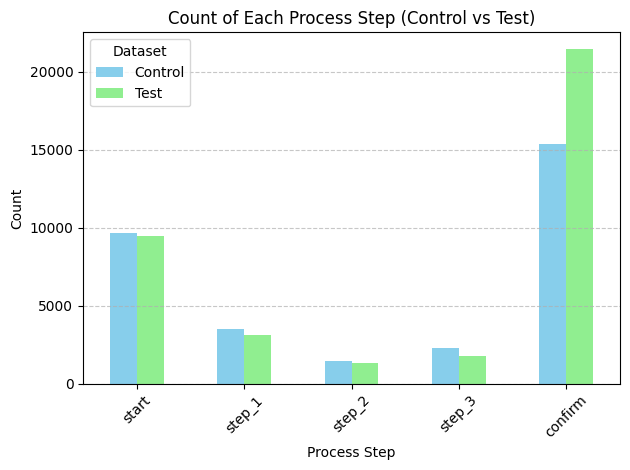

In [28]:

control_counts = df_control_last_step['process_step'].value_counts()
test_counts = df_test_last_step['process_step'].value_counts()

# Combine the counts into a single DataFrame
combined_counts = pd.DataFrame({
    'Control': control_counts,
    'Test': test_counts
}).fillna(0)

# Define the desired order of process steps
desired_order = ['start', 'step_1', 'step_2', 'step_3', 'confirm']

# Reindex the DataFrame to reflect the desired order
combined_counts = combined_counts.reindex(desired_order)

# Plot the combined counts
plt.figure(figsize=(12, 8))
combined_counts.plot(kind='bar', color=['skyblue', 'lightgreen'])
plt.title('Count of Each Process Step (Control vs Test)')
plt.xlabel('Process Step')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

In [29]:
df_test_timediff = df_test.sort_values(by=['visit_id', 'date_time'], ascending=[True, True])


# Define a function to calculate time differences for each visit_id
def calculate_time_differences(group):
    group = group.set_index('process_step')
    
    # Select the oldest step_1
    if 'step_1' in group.index:
        step1_times = group.loc['step_1', 'date_time']
        if isinstance(step1_times, pd.Series):
            oldest_step1_time = step1_times.min()
        else:
            oldest_step1_time = step1_times
    else:
        oldest_step1_time = pd.NaT
    
    # Select the latest step_3
    if 'step_3' in group.index:
        step3_times = group.loc['step_3', 'date_time']
        if isinstance(step3_times, pd.Series):
            latest_step3_time = step3_times.max()
        else:
            latest_step3_time = step3_times
    else:
        latest_step3_time = pd.NaT
        
    # Select the latest confirm
    if 'confirm' in group.index:
        confirm_times = group.loc['confirm', 'date_time']
        if isinstance(confirm_times, pd.Series):
            latest_confirm_time = confirm_times.max()
        else:
            latest_confirm_time = confirm_times
    else:
        latest_confirm_time = pd.NaT

    # Select the start time
    if 'start' in group.index:
        start_times = group.loc['start', 'date_time']
        if isinstance(start_times, pd.Series):
            start_time = start_times.min()  # Start time should be the earliest
        else:
            start_time = start_times
    else:
        start_time = pd.NaT
    
    result = {
        'time_start_to_step1': (oldest_step1_time - start_time).total_seconds() if not pd.isna(start_time) and not pd.isna(oldest_step1_time) else pd.NaT,
        'time_step1_to_step3': (latest_step3_time - oldest_step1_time).total_seconds() if not pd.isna(oldest_step1_time) and not pd.isna(latest_step3_time) else pd.NaT,
        'time_step3_to_confirm': (latest_confirm_time - latest_step3_time).total_seconds() if not pd.isna(latest_step3_time) and not pd.isna(latest_confirm_time) else pd.NaT,
        'total_time_start_to_confirm': (latest_confirm_time - start_time).total_seconds() if not pd.isna(start_time) and not pd.isna(latest_confirm_time) else pd.NaT
    }
    return pd.Series(result)

# Group by 'visit_id' and apply the function
time_differences_df_test = df_test_timediff.groupby('visit_id').apply(calculate_time_differences).reset_index()

time_differences_df_test.head(10)

C:\Users\reetu\AppData\Local\Temp\ipykernel_11456\3002305210.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  time_differences_df_test = df_test_timediff.groupby('visit_id').apply(calculate_time_differences).reset_index()


,visit_id,time_start_to_step1,time_step1_to_step3,time_step3_to_confirm,total_time_start_to_confirm
0,100012776_37918976071_457913,None,None,None,None
1,100019538_17884295066_43909,16.0,169.0,57.0,242.0
2,100022086_87870757897_149620,22.0,98.0,60.0,180.0
3,100173292_91322748906_143563,11.0,56.0,28.0,95.0
4,100217156_67053490690_383412,36.0,829.0,152.0,1017.0
5,100221419_95702886123_228743,None,None,None,None
6,100253265_79786188559_15799,61.0,73.0,NaT,NaT
7,100258507_71262593004_214494,210.0,692.0,111.0,1013.0
8,100293270_70949014562_696814,11.0,148.0,50.0,209.0
9,10029965_1592382589_593999,67.0,NaT,NaT,NaT


In [30]:

result = time_differences_df_test[time_differences_df['visit_id'] == '100217156_67053490690_383412']
result

NameError: name 'time_differences_df' is not defined

# Day 1 & 2 (Week 5)

Answer the following questions about demographics:

Who are the primary clients using this online process?
Are the primary clients younger or older, new or long-standing?


In [ ]:
result = df_test[df_test['visit_id'] == '100217156_67053490690_383412']
result

In [ ]:
# Displaying the data types of each column in the dataframe
df_test.dtypes

client_id                      int64
visitor_id                    object
visit_id                      object
process_step                  object
date_time             datetime64[ns]
Variation                     object
clnt_tenure_yr               float64
clnt_tenure_mnth             float64
clnt_age                     float64
gendr                         object
num_accts                    float64
bal                          float64
calls_6_mnth                 float64
logons_6_mnth                float64
backward_move                   bool
time_spent_seconds           float64
dtype: object

In [ ]:
# Displaying the data types of each column in the dataframe
df_control.dtypes

client_id                      int64
visitor_id                    object
visit_id                      object
process_step                  object
date_time             datetime64[ns]
Variation                     object
clnt_tenure_yr               float64
clnt_tenure_mnth             float64
clnt_age                     float64
gendr                         object
num_accts                    float64
bal                          float64
calls_6_mnth                 float64
logons_6_mnth                float64
backward_move                   bool
time_spent_seconds           float64
dtype: object

In [ ]:
# Retrieving the unique data types present in the df_test
list(set(df_test.dtypes.tolist()))

[dtype('<M8[ns]'), dtype('O'), dtype('float64'), dtype('int64'), dtype('bool')]

In [ ]:
# Retrieving the unique data types present in the df_control
list(set(df_control.dtypes.tolist()))

[dtype('<M8[ns]'), dtype('O'), dtype('float64'), dtype('int64'), dtype('bool')]

In [ ]:
# Extracting column names with numerical data types from the dataframe
df_test.select_dtypes("number").columns

Index(['client_id', 'clnt_tenure_yr', 'clnt_tenure_mnth', 'clnt_age',
       'num_accts', 'bal', 'calls_6_mnth', 'logons_6_mnth',
       'time_spent_seconds'],
      dtype='object')

In [ ]:
# Counting and sorting the unique values for each numerical column in descending order
df_test.select_dtypes("number").nunique().sort_values(ascending=False)

client_id             26961
bal                   26907
time_spent_seconds     3636
clnt_tenure_mnth        444
clnt_age                157
clnt_tenure_yr           49
num_accts                 7
calls_6_mnth              7
logons_6_mnth             7
dtype: int64

In [ ]:
# Extracting column names with numerical data types from the dataframe
df_control.select_dtypes("number").columns

Index(['client_id', 'clnt_tenure_yr', 'clnt_tenure_mnth', 'clnt_age',
       'num_accts', 'bal', 'calls_6_mnth', 'logons_6_mnth',
       'time_spent_seconds'],
      dtype='object')

In [ ]:
# Counting and sorting the unique values for each numerical column in descending order
df_control.select_dtypes("number").nunique().sort_values(ascending=False)

client_id             23526
bal                   23488
time_spent_seconds     2994
clnt_tenure_mnth        443
clnt_age                155
clnt_tenure_yr           52
calls_6_mnth              7
logons_6_mnth             7
num_accts                 6
dtype: int64

In [ ]:
import numpy as np
import scipy.stats as stats

n_test = df_test.shape[0]
x_test = df_test[df_test['process_step'] == 'confirm'].shape[0]

# Step 2: Calculate n_control and x_control
n_control = df_control.shape[0]
x_control = df_control[df_control['process_step'] == 'confirm'].shape[0]

# Step 3: Calculate completion rates
p_test = x_test / n_test
p_control = x_control / n_control
p_pooled = (x_test + x_control) / (n_test + n_control)

# Step 4: Calculate standard error
se = np.sqrt(p_pooled * (1 - p_pooled) * (1/n_test + 1/n_control))

# Step 5: Calculate z-score for two-proportion z-test
z = (p_test - p_control) / se

# Step 6: Calculate p-value for two-proportion z-test
p_value = 2 * (1 - stats.norm.cdf(abs(z)))

# Conclusion for two-proportion z-test
if p_value < 0.05:
    print("Reject the null hypothesis: The completion rates are significantly different.")
else:
    print("Fail to reject the null hypothesis: The completion rates are not significantly different.")
print(f"p-value: {p_value}")


Reject the null hypothesis: The completion rates are significantly different.
p-value: 0.0


In [ ]:
#Hypothesis test for cost-effectiveness threshold
threshold = 0.05
delta_p = p_test - p_control

# Calculate z-score for one-sided test
z_threshold = (delta_p - threshold) / se

# Calculate p-value for one-sided test
p_value_threshold = 1 - stats.norm.cdf(z_threshold)

# Conclusion for cost-effectiveness threshold test
if p_value_threshold < 0.05:
    print("Reject the null hypothesis: The completion rate increase meets or exceeds the 5% threshold.")
else:
    print("Fail to reject the null hypothesis: The completion rate increase does not meet the 5% threshold.")
print(f"p-value (threshold): {p_value_threshold}")

Fail to reject the null hypothesis: The completion rate increase does not meet the 5% threshold.
p-value (threshold): 1.0


In [ ]:
from scipy.stats import ttest_ind
ages_test = df_test['clnt_age']
ages_control = df_control['clnt_age']

# Calculate the average age for both groups
average_age_test = np.mean(ages_test)
average_age_control = np.mean(ages_control)

# Perform an independent two-sample t-test
t_stat, p_value = ttest_ind(ages_test, ages_control, equal_var=False)

# Print the average ages
print(f"Average age in test group: {average_age_test}")
print(f"Average age in control group: {average_age_control}")

# Conclusion
if p_value < 0.05:
    print("Reject the null hypothesis: The average ages are significantly different.")
else:
    print("Fail to reject the null hypothesis: The average ages are not significantly different.")
print(f"t-statistic: {t_stat}, p-value: {p_value}")

Average age in test group: 48.6947081635941
Average age in control group: 48.243816441116174
Reject the null hypothesis: The average ages are significantly different.
t-statistic: 8.063860111884294, p-value: 7.418818756917273e-16


In [ ]:
df_test['age_category'] = df_test['clnt_age'].apply(categorize_age)
df_control['age_category'] = df_control['clnt_age'].apply(categorize_age)

# Step 2: Calculate completion rates by age group
completion_rates_test = df_test[df_test['process_step'] == 'confirm'].groupby('age_category').size() / df_test.groupby('age_category').size()
completion_rates_control = df_control[df_control['process_step'] == 'confirm'].groupby('age_category').size() / df_control.groupby('age_category').size()

# Print completion rates for all age groups
print("Completion rates for test group by age category:")
print(completion_rates_test)

print("\nCompletion rates for control group by age category:")
print(completion_rates_control)

# Determine if 'young adults' has the highest completion rate
def perform_hypothesis_testing(df, age_group):
    # Filter the data for the age group in question
    age_group_data = df[df['age_category'] == age_group]
    
    # Calculate completion rate for the given age group
    completion_rate_age_group = age_group_data[age_group_data['process_step'] == 'confirm'].shape[0] / age_group_data.shape[0]
    
    # Perform a t-test between the given age group and other age groups
    other_groups_data = df[df['age_category'] != age_group]
    completion_rate_other_groups = other_groups_data[other_groups_data['process_step'] == 'confirm'].shape[0] / other_groups_data.shape[0]
    
    # Perform t-test
    t_stat, p_value = ttest_ind(age_group_data['clnt_age'], other_groups_data['clnt_age'], equal_var=False)
    
    return completion_rate_age_group, completion_rate_other_groups, t_stat, p_value

# Perform hypothesis testing for the 'young adults' group in test and control groups
for group in ['test', 'control']:
    df = df_test if group == 'test' else df_control
    completion_rate_age_group, completion_rate_other_groups, t_stat, p_value = perform_hypothesis_testing(df, 'young adults')
    
    print(f"\nIn the {group} group:")
    print(f"Completion rate for young adults: {completion_rate_age_group}")
    print(f"Completion rate for other age groups: {completion_rate_other_groups}")
    
    # Conclusion
    if p_value < 0.05:
        print(f"Reject the null hypothesis: The completion rate for young adults is significantly different from other age groups.")
    else:
        print(f"Fail to reject the null hypothesis: The completion rate for young adults is not significantly different from other age groups.")
    
    print(f"t-statistic: {t_stat}, p-value: {p_value}")


Completion rates for test group by age category:
age_category
middle-age adults    0.128208
senior               0.112189
teen                 0.147415
young adults         0.138439
dtype: float64

Completion rates for control group by age category:
age_category
middle-age adults    0.117863
senior               0.100180
teen                 0.131083
young adults         0.119170
dtype: float64

In the test group:
Completion rate for young adults: 0.1384391700723043
Completion rate for other age groups: 0.12269798042440748
Reject the null hypothesis: The completion rate for young adults is significantly different from other age groups.
t-statistic: -699.8108287861871, p-value: 0.0

In the control group:
Completion rate for young adults: 0.11916977611940298
Completion rate for other age groups: 0.11189205785460007
Reject the null hypothesis: The completion rate for young adults is significantly different from other age groups.
t-statistic: -625.8138873028544, p-value: 0.0


In [ ]:
def categorize_age(age):
    if age < 20:
        return 'teen'
    elif 20 <= age < 30:
        return 'young adults'
    elif 30 <= age < 60:
        return 'middle-age adults'
    else:
        return 'senior'

df_test['age_category'] = df_test['clnt_age'].apply(categorize_age)

# Calculate number of users and completion rates by age category
user_counts_by_age = df_test['age_category'].value_counts().reset_index()
user_counts_by_age.columns = ['age_category', 'user_count']

completion_rates = df_test[df_test['process_step'] == 'confirm'].groupby('age_category').size() / df.groupby('age_category').size()

print("Completion rates by age category:")
print(completion_rates)

def perform_hypothesis_testing(df_test, age_category):
    # Filter data for the target age category
    target_data = df[df['age_category'] == age_category]
    
    # Calculate completion rate for the target age category
    completion_rate_target = target_data[target_data['process_step'] == 'confirm'].shape[0] / target_data.shape[0]
    
    # Calculate completion rate for other age categories
    other_data = df_test[df_test['age_category'] != age_category]
    completion_rate_other = other_data[other_data['process_step'] == 'confirm'].shape[0] / other_data.shape[0]
    
    # Perform t-test on user counts
    t_stat, p_value = ttest_ind(
        target_data['client_id'].value_counts(), 
        other_data['client_id'].value_counts(), 
        equal_var=False
    )
    
    return completion_rate_target, completion_rate_other, t_stat, p_value

# Example hypothesis testing for 'middle-age adults'
completion_rate_middle_age, completion_rate_other, t_stat, p_value = perform_hypothesis_testing(df, 'middle-age adults')

print(f"\nCompletion rate for middle-age adults: {completion_rate_middle_age}")
print(f"Completion rate for other age categories: {completion_rate_other}")

# Conclusion
if p_value < 0.05:
    print(f"Reject the null hypothesis: The completion rate for middle-age adults is highest.")
else:
    print(f"Fail to reject the null hypothesis: The completion rate for middle-age adults is not highest.")
    
print(f"t-statistic: {t_stat}, p-value: {p_value}")

Completion rates by age category:
age_category
middle-age adults    0.154251
senior               0.143191
teen                 0.181319
young adults         0.164319
dtype: float64

Completion rate for middle-age adults: 0.11716362740266141
Completion rate for other age categories: 0.10742075046472224
Reject the null hypothesis: The completion rate for middle-age adults is highest.
t-statistic: -3.8637462946867402, p-value: 0.00011200492620896888


In [ ]:
def categorize_age(age):
    if age < 20:
        return 'teen'
    elif 20 <= age < 30:
        return 'young adults'
    elif 30 <= age < 60:
        return 'middle-age adults'
    else:
        return 'senior'

df_control['age_category'] = df_control['clnt_age'].apply(categorize_age)

# Calculate number of users and completion rates by age category
user_counts_by_age = df['age_category'].value_counts().reset_index()
user_counts_by_age.columns = ['age_category', 'user_count']

completion_rates = df_control[df_control['process_step'] == 'confirm'].groupby('age_category').size() / df_control.groupby('age_category').size()

print("Completion rates by age category:")
print(completion_rates)

def perform_hypothesis_testing(df_control, age_category):
    # Filter data for the target age category
    target_data = df[df['age_category'] == age_category]
    
    # Calculate completion rate for the target age category
    completion_rate_target = target_data[target_data['process_step'] == 'confirm'].shape[0] / target_data.shape[0]
    
    # Calculate completion rate for other age categories
    other_data = df_control[df_control['age_category'] != age_category]
    completion_rate_other = other_data[other_data['process_step'] == 'confirm'].shape[0] / other_data.shape[0]
    
    # Perform t-test on user counts
    t_stat, p_value = ttest_ind(
        target_data['client_id'].value_counts(), 
        other_data['client_id'].value_counts(), 
        equal_var=False
    )
    
    return completion_rate_target, completion_rate_other, t_stat, p_value

# Example hypothesis testing for 'middle-age adults'
completion_rate_middle_age, completion_rate_other, t_stat, p_value = perform_hypothesis_testing(df, 'middle-age adults')

print(f"\nCompletion rate for middle-age adults: {completion_rate_middle_age}")
print(f"Completion rate for other age categories: {completion_rate_other}")

# Conclusion
if p_value < 0.05:
    print(f"Reject the null hypothesis: The completion rate for middle-age adults is highest.")
else:
    print(f"Fail to reject the null hypothesis: The completion rate for middle-age adults is not highest.")
    
print(f"t-statistic: {t_stat}, p-value: {p_value}")

Completion rates by age category:
age_category
middle-age adults    0.117164
senior               0.100013
teen                 0.131083
young adults         0.119170
dtype: float64

Completion rate for middle-age adults: 0.11716362740266141
Completion rate for other age categories: 0.10742075046472224
Reject the null hypothesis: The completion rate for middle-age adults is highest.
t-statistic: -3.8637462946867402, p-value: 0.00011200492620896888


C:\Users\reetu\AppData\Local\Temp\ipykernel_21692\2255519566.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=completion_rates_df, y='age_category', x='completion_rate', palette='viridis')


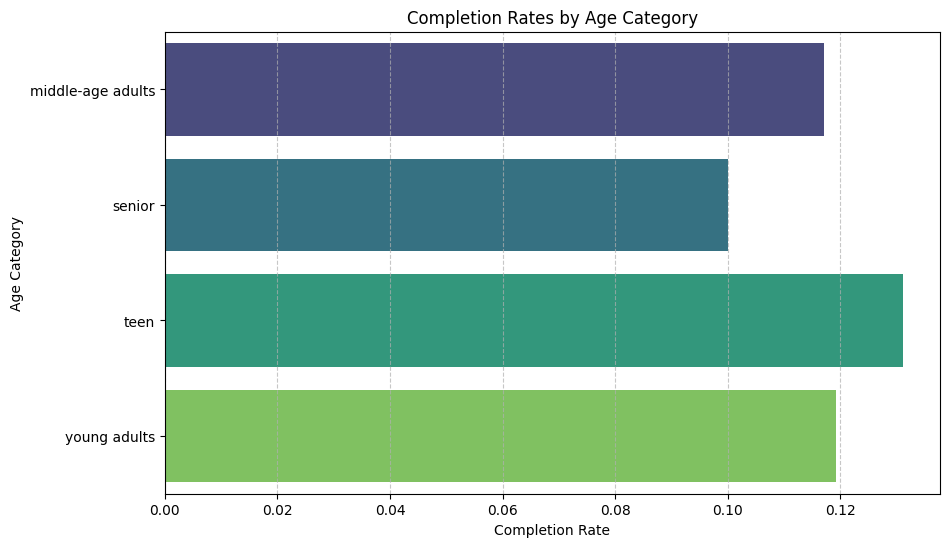

In [ ]:
completion_rates_df = completion_rates.reset_index()
completion_rates_df.columns = ['age_category', 'completion_rate']

# Plot horizontal bar graph
plt.figure(figsize=(10, 6))
sns.barplot(data=completion_rates_df, y='age_category', x='completion_rate', palette='viridis')

# Add titles and labels
plt.title('Completion Rates by Age Category')
plt.xlabel('Completion Rate')
plt.ylabel('Age Category')

# Show plot
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

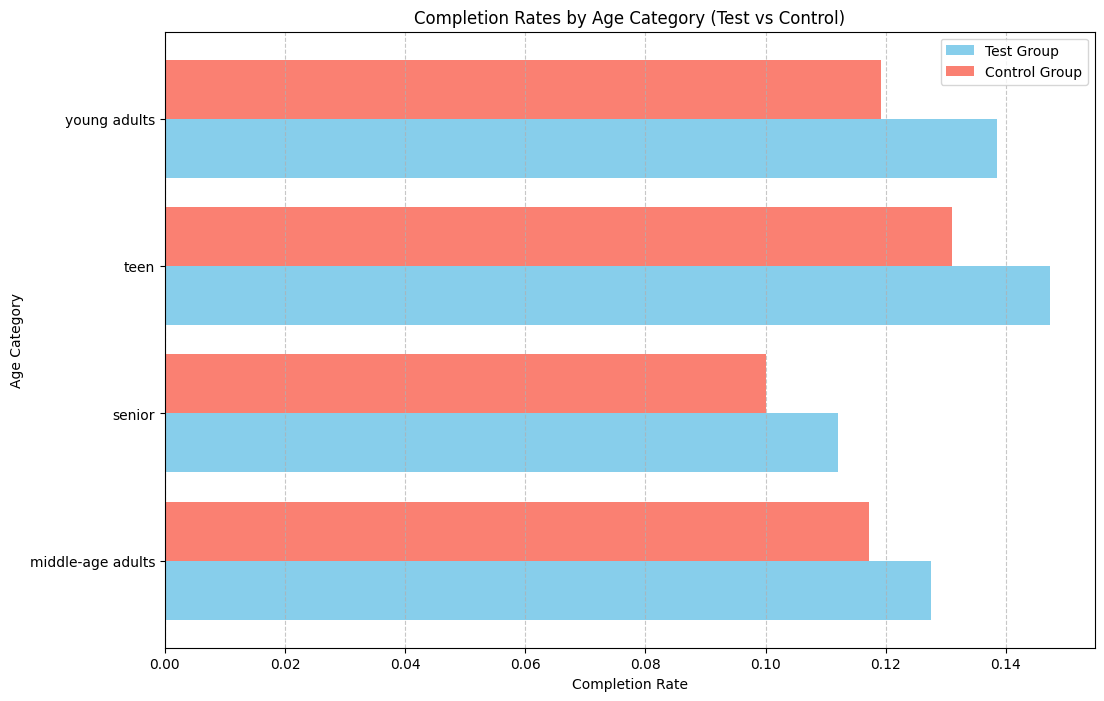

In [ ]:
df_test['age_category'] = df_test['clnt_age'].apply(categorize_age)
df_control['age_category'] = df_control['clnt_age'].apply(categorize_age)

# Calculate completion rates for both dataframes
completion_rates_test = df_test[df_test['process_step'] == 'confirm'].groupby('age_category').size() / df_test.groupby('age_category').size()
completion_rates_control = df_control[df_control['process_step'] == 'confirm'].groupby('age_category').size() / df_control.groupby('age_category').size()

# Convert completion rates to DataFrames
completion_rates_test_df = completion_rates_test.reset_index()
completion_rates_test_df.columns = ['age_category', 'completion_rate_test']
completion_rates_control_df = completion_rates_control.reset_index()
completion_rates_control_df.columns = ['age_category', 'completion_rate_control']

# Merge completion rates into a single DataFrame
combined_completion_rates = pd.merge(completion_rates_test_df, completion_rates_control_df, on='age_category')
# Plot horizontal bar graph
plt.figure(figsize=(12, 8))

# Define bar width
bar_width = 0.4

# Define position of bars on Y-axis
age_categories = combined_completion_rates['age_category']
bar_positions = np.arange(len(age_categories))

# Plot bars
plt.barh(bar_positions - bar_width/2, combined_completion_rates['completion_rate_test'], 
         height=bar_width, color='skyblue', label='Test Group')
plt.barh(bar_positions + bar_width/2, combined_completion_rates['completion_rate_control'], 
         height=bar_width, color='salmon',  label='Control Group')

# Add titles and labels
plt.title('Completion Rates by Age Category (Test vs Control)')
plt.xlabel('Completion Rate')
plt.ylabel('Age Category')
plt.yticks(bar_positions, age_categories)  # Set the y-axis ticks to age categories

# Add a legend
plt.legend()

# Show plot
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [ ]:

#Categorize ages
df_test['age_category'] = df_test['clnt_age'].apply(categorize_age)
df_control['age_category'] = df_control['clnt_age'].apply(categorize_age)

# Step 3: Combine the test and control dataframes
df_test['group'] = 'Test'
df_control['group'] = 'Control'
df_combined = pd.concat([df_test, df_control])

# Step 4: Count the number of completions and non-completions by age group and interaction type
interaction_counts = df_combined.groupby(['age_category', 'process_step', 'group']).size().reset_index(name='count')

# Step 5: Plot the distribution of users by age category and their interactions
plt.figure(figsize=(14, 8))
sns.barplot(x='age_category', y='count', hue='process_step', data=interaction_counts, ci=None)
plt.title('Distribution of Users by Age Category and Interaction with Website')
plt.xlabel('Age Category')
plt.ylabel('Number of Users')
plt.legend(title='Process Step', labels=['Other Steps', 'Confirm'])
plt.show()

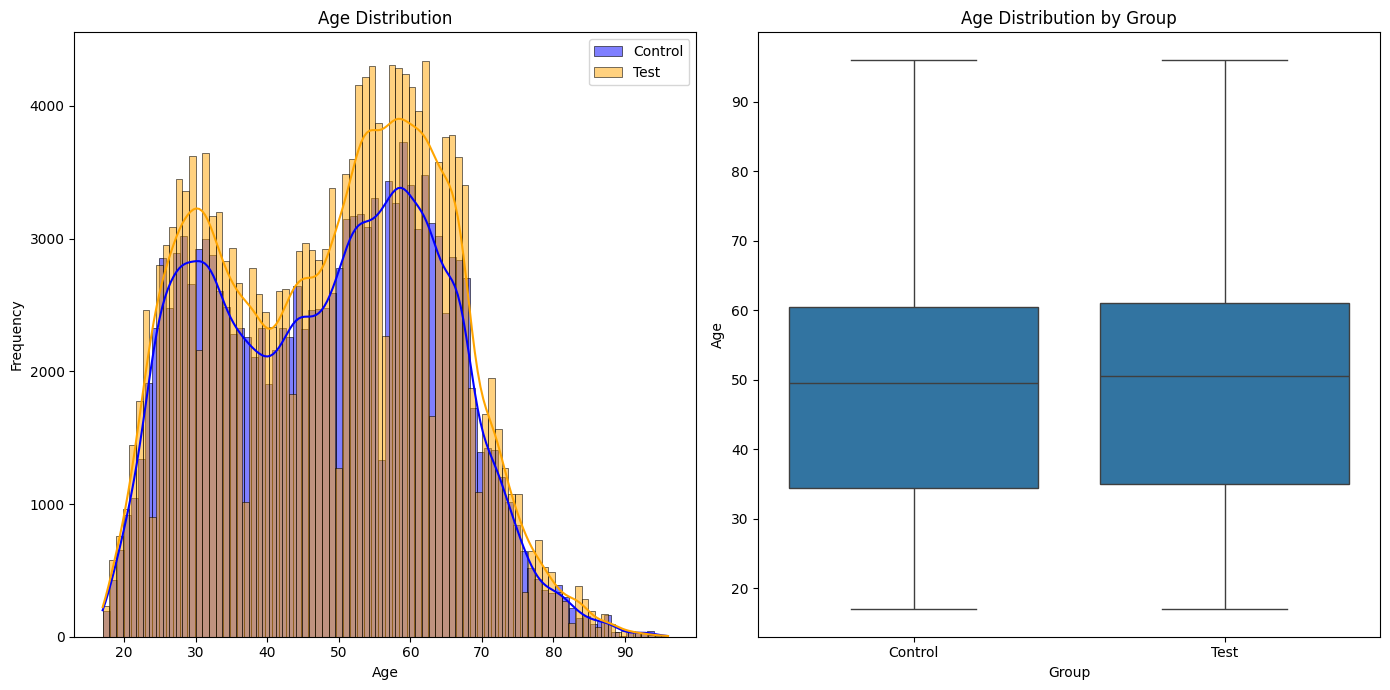

In [ ]:
plt.figure(figsize=(14, 7))

# Histogram for age distribution
plt.subplot(1, 2, 1)
sns.histplot(df_control['clnt_age'], color='blue', label='Control', kde=True)
sns.histplot(df_test['clnt_age'], color='orange', label='Test', kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()

# Boxplot for age distribution
plt.subplot(1, 2, 2)
sns.boxplot(x='group', y='clnt_age', data=pd.concat([df_control.assign(group='Control'), df_test.assign(group='Test')]))
plt.title('Age Distribution by Group')
plt.xlabel('Group')
plt.ylabel('Age')

plt.tight_layout()
plt.show()

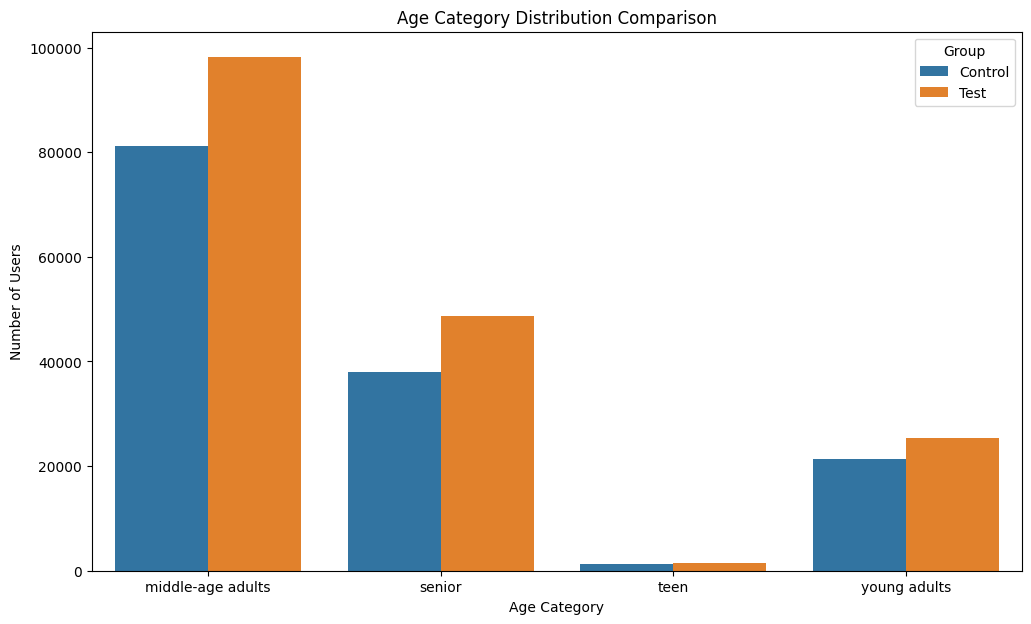

In [ ]:
df_control['age_category'] = df_control['clnt_age'].apply(categorize_age)
df_test['age_category'] = df_test['clnt_age'].apply(categorize_age)

# Combine for comparison
df_combined_age = pd.concat([
    df_control[['age_category']].assign(group='Control'),
    df_test[['age_category']].assign(group='Test')
])

# Count the number of users in each age category
age_category_counts = df_combined_age.groupby(['age_category', 'group']).size().reset_index(name='count')

plt.figure(figsize=(12, 7))
sns.barplot(x='age_category', y='count', hue='group', data=age_category_counts)
plt.title('Age Category Distribution Comparison')
plt.xlabel('Age Category')
plt.ylabel('Number of Users')
plt.legend(title='Group')
plt.show()

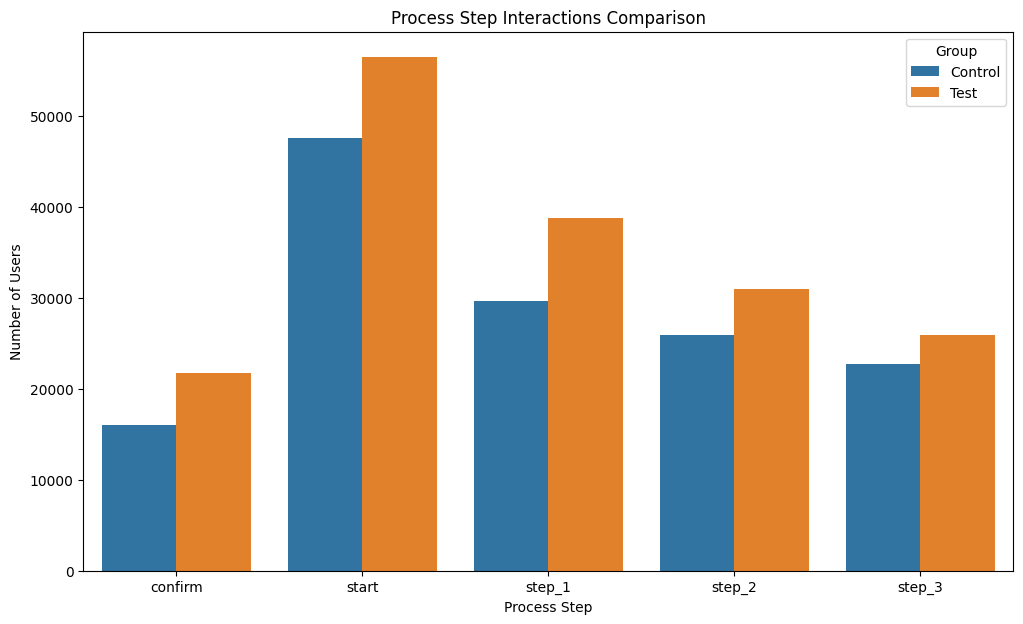

In [ ]:
process_step_counts = df_combined.groupby(['process_step', 'group']).size().reset_index(name='count')

plt.figure(figsize=(12, 7))
sns.barplot(x='process_step', y='count', hue='group', data=process_step_counts)
plt.title('Process Step Interactions Comparison')
plt.xlabel('Process Step')
plt.ylabel('Number of Users')
plt.legend(title='Group')
plt.show()

In [ ]:
scaler = StandardScaler()
df_no_outliers['scaled_total_navigations'] = scaler.fit_transform(df_no_outliers[['total_time_visit']])

# Creating the violin plot with scaled data
plt.figure(figsize=(10, 6))
sns.violinplot(x='completion', y='total_time_visit', data=df_no_outliers)
plt.title('Violin Plot of Scaled Total Navigations by Category')
plt.show()